In [2]:
import os, tensorflow as tf, numpy as np, matplotlib.pyplot as plt, pandas as pd, cv2, keras
from pathlib import Path
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

print(tf.__version__)

2.16.1


In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/animal-image-classification-dataset/README.md
/kaggle/input/animal-image-classification-dataset/Animals/snakes/2_0802.jpg
/kaggle/input/animal-image-classification-dataset/Animals/snakes/2_0714.jpg
/kaggle/input/animal-image-classification-dataset/Animals/snakes/2_0894.jpg
/kaggle/input/animal-image-classification-dataset/Animals/snakes/2_0045.jpg
/kaggle/input/animal-image-classification-dataset/Animals/snakes/2_0690.jpg
/kaggle/input/animal-image-classification-dataset/Animals/snakes/2_0426.jpg
/kaggle/input/animal-image-classification-dataset/Animals/snakes/2_0800.jpg
/kaggle/input/animal-image-classification-dataset/Animals/snakes/2_0010.jpg
/kaggle/input/animal-image-classification-dataset/Animals/snakes/2_0220.jpg
/kaggle/input/animal-image-classification-dataset/Animals/snakes/2_0098.jpg
/kaggle/input/animal-image-classification-dataset/Animals/snakes/2_0736.jpg
/kaggle/input/animal-image-classification-dataset/Animals/snakes/2_0995.jpg
/kaggle/input/animal-image-c

In [4]:
# Initial Hyperparameter Tuning
rs = 42 # Random State
sz = 224 # Image and Model Input Size
lr = 0.001 # Learning Rate
bs = 30 # Batch Size

In [5]:
# Preparing Dataset
# Define the path to your dataset
from sklearn.model_selection import train_test_split as tts

ds_path = "/kaggle/input/animal-image-classification-dataset/Animals"  # Make sure this path is correct
fldr = os.listdir(ds_path)
print(f"Folders in 'ds_path':\n{os.listdir(ds_path)}")
print()

for cate in fldr:
    path=os.path.join(ds_path, cate)
    print(f'{cate} images: {len(os.listdir(path))}')
print()

imgs = []
lbls = []

for cate in fldr:
    folder_path = os.path.join(ds_path, cate)
    for image_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, image_name)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Unable to load image '{img_path}'. Skipping this file.")
            continue
        img = cv2.resize(img, (sz, sz))
        imgs.append(img)
        lbls.append(fldr.index(cate))

print('Amount of Images:',len(imgs))
print('Amount of Labels:',len(lbls))

imgs = np.array(imgs)
lbls = np.array(lbls)

classes = tf.keras.utils.to_categorical(lbls, num_classes = 3)
print(classes)

# Splitting Dataset
xtr, xts, ytr, yts = tts(imgs, classes, test_size = 0.2, random_state = rs)
xts, xvl, yts, yvl = tts(xts, yts, test_size = 0.5, random_state = rs)

print(f"\nTraining Set Size:\nX: {xtr.shape}\nY: {ytr.shape}")
print(f"\nValidation Set Size:\nX: {xvl.shape}\nY: {yvl.shape}")
print(f"\nTest Set Size:\nX: {xts.shape}\nY: {yts.shape}")

tr_dtg = ImageDataGenerator(rescale=1./255,rotation_range=20,shear_range=0.2, zoom_range=0.2,horizontal_flip=True)
val_dtg = ImageDataGenerator(rescale=1./255)
ts_dtg = ImageDataGenerator(rescale=1./255)

tr_g = tr_dtg.flow(xtr, ytr, batch_size = bs)
ts_g = ts_dtg.flow(xts, yts, batch_size = bs)
val_g = val_dtg.flow(xvl, yvl, batch_size = bs)

Folders in 'ds_path':
['snakes', 'dogs', 'cats']

snakes images: 1000
dogs images: 1000
cats images: 1000

Amount of Images: 3000
Amount of Labels: 3000
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]

Training Set Size:
X: (2400, 224, 224, 3)
Y: (2400, 3)

Validation Set Size:
X: (300, 224, 224, 3)
Y: (300, 3)

Test Set Size:
X: (300, 224, 224, 3)
Y: (300, 3)


First 5 snakes images:


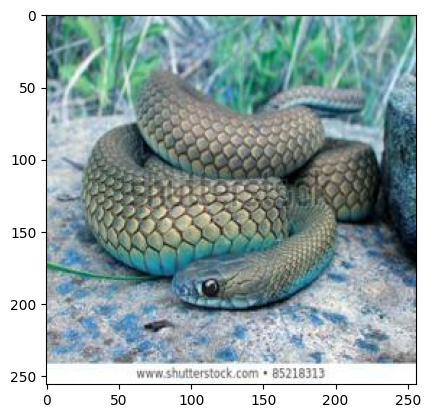

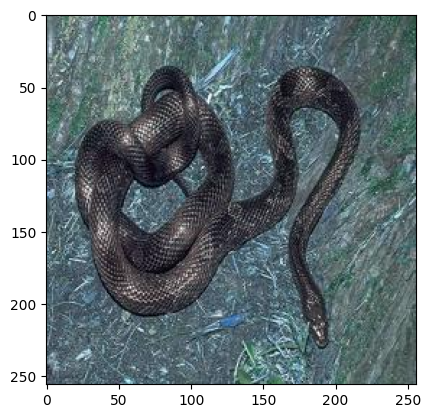

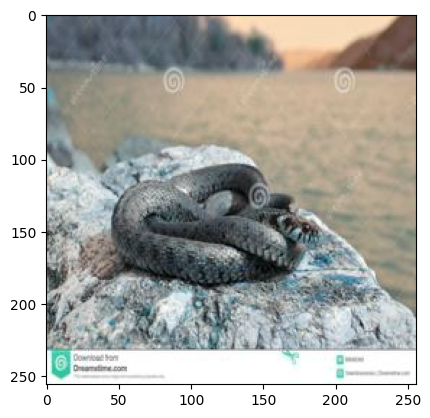

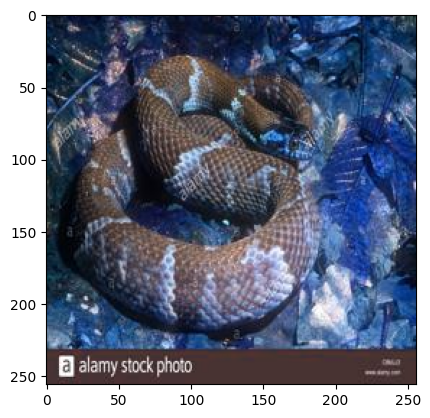

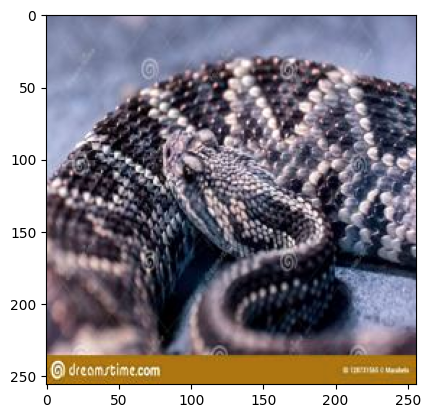

First 5 dogs images:


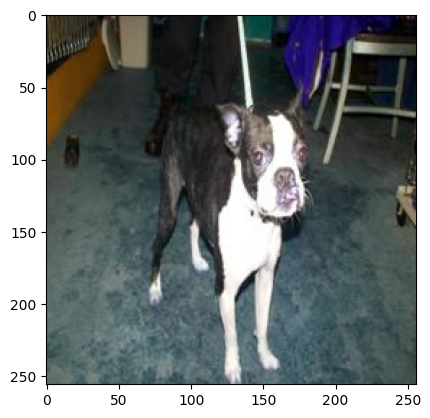

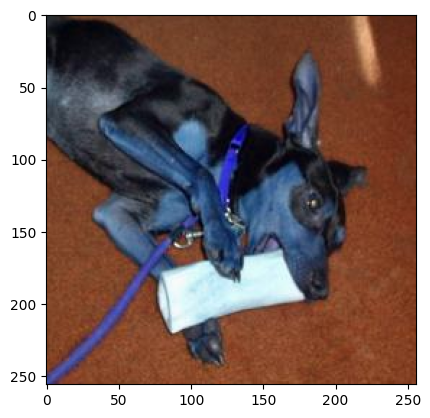

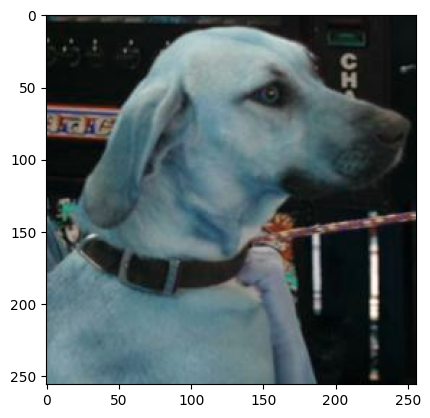

First 5 cats images:


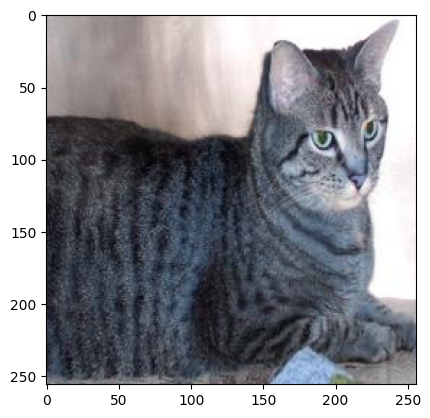

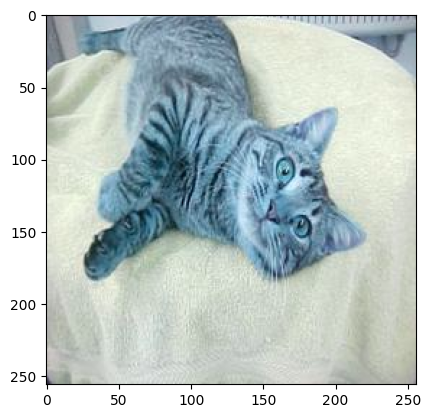

In [6]:
# Plotting Images

for cate in fldr:
        fl_path = os.path.join(ds_path, cate)
        print(f'First 5 {cate} images:')
        x=0
        for img in os.listdir(fl_path):
            img_path =os.path.join(fl_path, img)
            plt.imshow(cv2.imread(img_path))
            plt.show()
            x+=1
            if x==5:
                break

In [7]:
# Loading VGG16 Base Model
base_mod = VGG16(weights = 'imagenet', include_top = False, input_shape = (sz, sz, 3))
for lyr in base_mod.layers:
  lyr.trainable = False

# LR Reduction
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, mode='min')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
# Model Architecture
mod = keras.models.Sequential([
    base_mod,
    GlobalAveragePooling2D(),
    Dense(1024, activation = 'relu'),
    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(3, activation = 'softmax')
])

mod.compile(optimizer=Adam(learning_rate= lr), loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = mod.fit(tr_g, epochs = 40, validation_data = val_g, verbose = 1, callbacks = [reduce_lr])

Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1748283135.321786     106 service.cc:145] XLA service 0x7a12c8003310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748283135.321871     106 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748283135.321879     106 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/80 ━━━━━━━━━━━━━━━━━━━━ 26:24 20s/step - accuracy: 0.2333 - loss: 1.1351

I0000 00:00:1748283151.156437     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


80/80 ━━━━━━━━━━━━━━━━━━━━ 43s 285ms/step - accuracy: 0.6177 - loss: 0.7715 - val_accuracy: 0.9100 - val_loss: 0.2816 - learning_rate: 0.0010
Epoch 2/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 278ms/step - accuracy: 0.8738 - loss: 0.2984 - val_accuracy: 0.9133 - val_loss: 0.2259 - learning_rate: 0.0010
Epoch 3/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 279ms/step - accuracy: 0.9054 - loss: 0.2539 - val_accuracy: 0.9200 - val_loss: 0.1916 - learning_rate: 0.0010
Epoch 4/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 278ms/step - accuracy: 0.9110 - loss: 0.2136 - val_accuracy: 0.9233 - val_loss: 0.1923 - learning_rate: 0.0010
Epoch 5/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 277ms/step - accuracy: 0.9152 - loss: 0.2074 - val_accuracy: 0.8833 - val_loss: 0.2927 - learning_rate: 0.0010
Epoch 6/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 275ms/step - accuracy: 0.9041 - loss: 0.2283 - val_accuracy: 0.8967 - val_loss: 0.2527 - learning_rate: 0.0010
Epoch 7/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 271ms/step - accuracy: 0.9157 - loss: 0.2025 - val_

In [9]:
# Saving Weights in a 'weights.h5' file
mod.save_weights('model_vgg16_gap2d.weights.h5')

# To Load Weights for Further Training:

# mod = keras.models.Sequential([
#     base_mod,
#     GlobalAveragePooling2D(),
#     Dense(1024, activation = 'relu'),
#     Dense(512, activation = 'relu'),
#     Dense(256, activation = 'relu'),
#     Dense(128, activation = 'relu'),
#     Dense(3, activation = 'softmax')
# ])

# mod.compile(optimizer=Adam(learning_rate= 4e-5), loss = 'categorical_crossentropy', metrics = ['accuracy'])
# mod.build((None, sz, sz, 3))
# mod.load_weights('mod1_vgg16_gap2d_240824.weights.h5')
# history = mod.fit(tr_g, epochs = 20, validation_data = val_g, verbose = 1, callbacks = [reduce_lr])

In [10]:
# Model Summary
mod.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,358,859 (70.03 MB)

 Trainable params: 1,214,723 (4.63 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 2,429,448 (9.27 MB)

In [11]:
mod.save('model.h5')


In [12]:
# Showing Model Accuracy on Test Set
loss,acc = mod.evaluate(ts_g)
print(f"Loss     = {loss}")
print(f"Accuracy = {acc}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9755 - loss: 0.1024
Loss     = 0.1218876764178276
Accuracy = 0.9633333086967468


In [13]:
# Accuracy Plotting
plt.plot(history.history['accuracy'],label='Tr. Acc')
plt.plot(history.history['val_accuracy'],label='Val. Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
# Loss Plotting
plt.plot(history.history['loss'],label='Tr. Loss')
plt.plot(history.history['val_loss'],label='Val. Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
# Classification Report
from sklearn.metrics import confusion_matrix as cfs_mtx,classification_report

ts_img = np.concatenate([ts_g[i][0] for i in range(len(ts_g))])
y_pr = mod.predict(ts_img)
y_pr = np.argmax(y_pr,axis=1)

lbl = np.concatenate([ts_g[i][1] for i in range(len(ts_g))])
lbl = np.argmax(lbl,axis=1)

cls_rpt = classification_report(lbl,y_pr)
print('Classification Report: \n', cls_rpt)

10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 898ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       114
           1       0.95      0.95      0.95        99
           2       0.95      0.94      0.95        87

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300



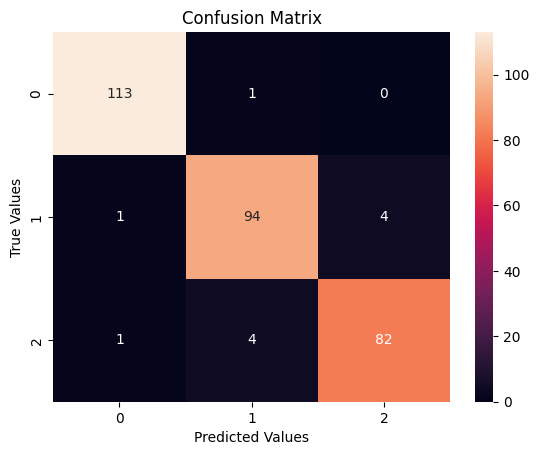

In [16]:
# Confusion Matrix
import seaborn as sns

cm = cfs_mtx(lbl, y_pr)
sns.heatmap(cm,fmt='d', annot=True)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Confusion Matrix')
plt.show()